Loading normalized data from HDF5...


/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Splitting X to test and train datasets...
Select max 5000 samples for training...
analysis : training samples = 2409.0 | total samples = 2677
backdoor : training samples = 2096.0 | total samples = 2329
dos : training samples = 5000 | total samples = 16353
exploits : training samples = 5000 | total samples = 44525
fuzzers : training samples = 5000 | total samples = 24246
generic : training samples = 5000 | total samples = 215481
normal : training samples = 31000 | total samples = 2218456
reconnaissance : training samples = 5000 | total samples = 13987
shellcode : training samples = 1359.0 | total samples = 1511
worms : training samples = 156.0 | total samples = 174
Number of categories is 9 | Total samples in categories:
| 0: 2677
|1: 2329
|2: 16353
|3: 44525
|4: 24246
|5: 215481
|6: 13987
|7: 1511
|8: 174
normal samples for rf: 31000
normal samples for nn: 5000
Finding feature importances with ExtraTreesClassifier


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


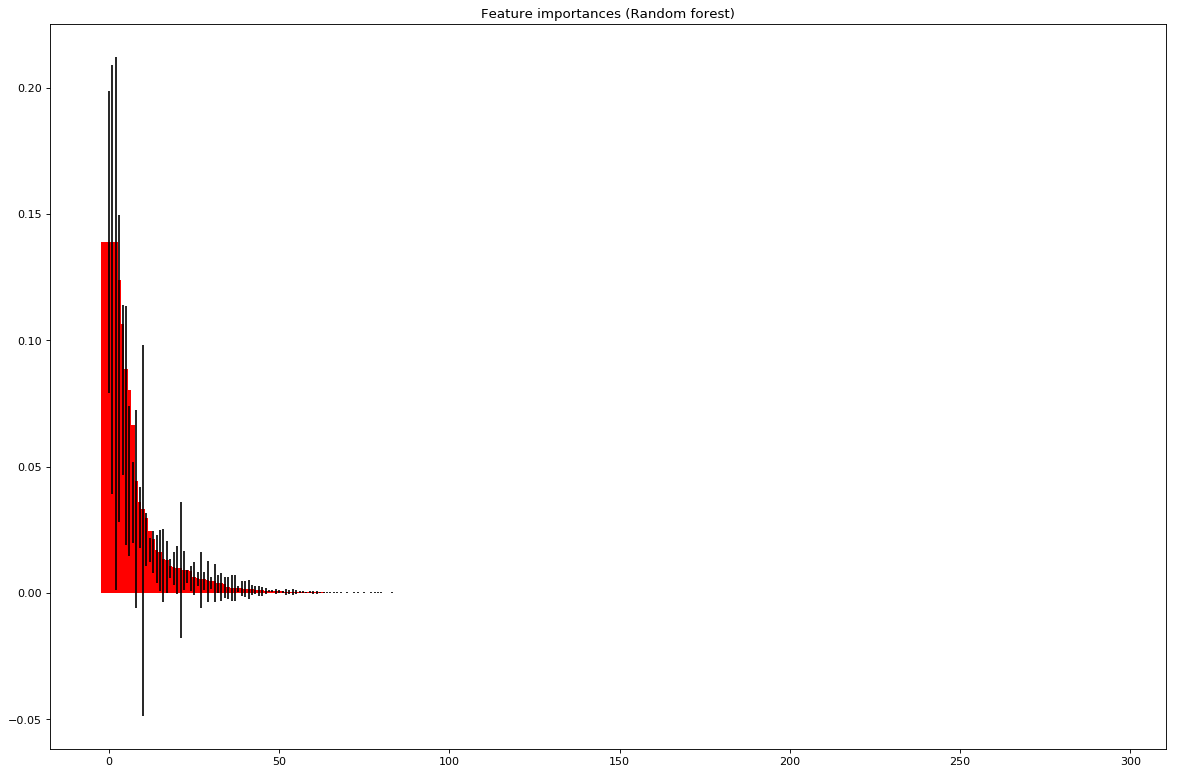

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


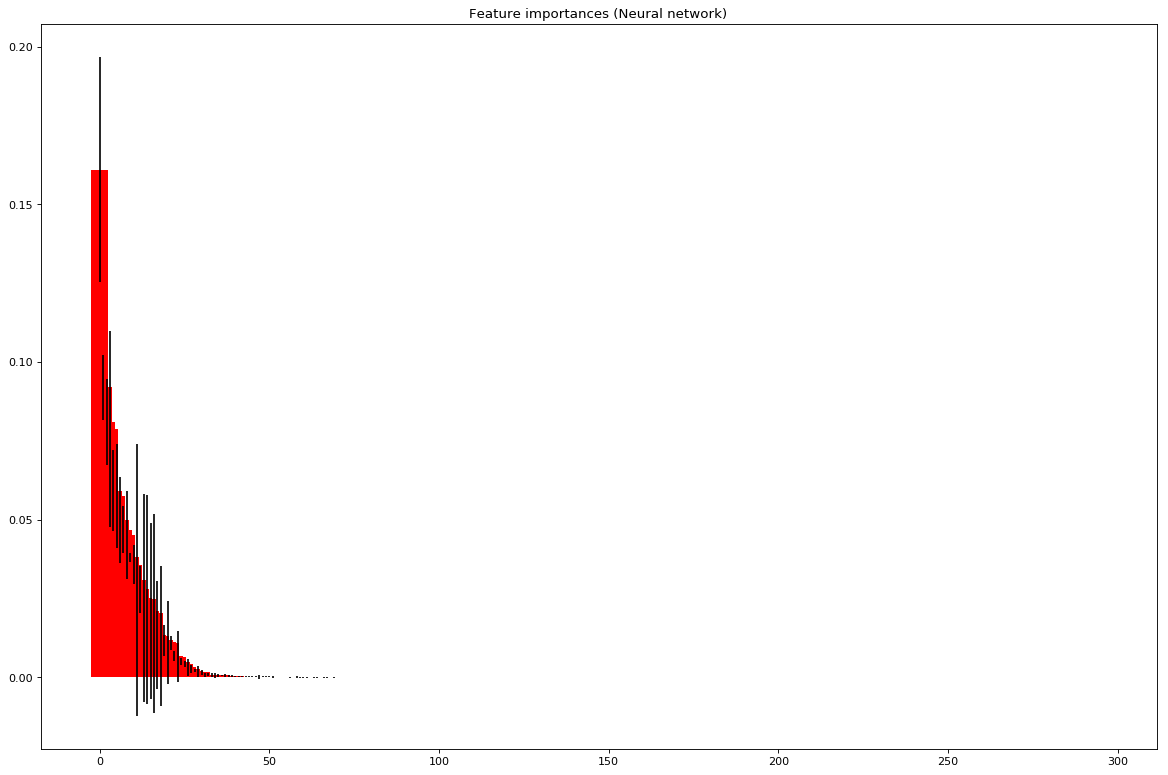

Saving X and Y to HDF5


In [2]:
print('Loading normalized data from HDF5...')
import h5py
import numpy as np
import pandas 

h5f = h5py.File('data.h5', 'r')
normalized_X = h5f['normalized_X'].value
labeled_Y = h5f['labeled_Y'].value
Y = h5f['Y'].value
Y_A = h5f['Y_A'].value
h5f.close()


print('Splitting X to test and train datasets...')
# X_test, X_train, Y_test, Y_train = []
rf_normal_inds = []
nn_normal_inds = []
inds = []

attack_cats = np.unique(Y)
cat_sizes = []
np.random.seed(1337)
max_training_samples = 5000
print('Select max', max_training_samples, 'samples for training...')
for cat in attack_cats:
    indices = np.ix_(Y == cat)[0]
    # total_num_of_samples = indices.shape[0]
    np.random.shuffle(indices)
    if cat == 'normal':
        len_of_subset = min(np.floor(len(indices)*0.9), 31000)
        rf_normal_inds = indices[:len_of_subset]
        nn_normal_inds = indices[:len_of_subset][:max_training_samples]
        cat_size = len(indices)
        print(cat, ': training samples =', len_of_subset, '| total samples =', cat_size)
    else:
        len_of_subset = min(np.floor(len(indices)*0.9), max_training_samples)

        cat_size = len(indices)
        print(cat, ': training samples =', len_of_subset, '| total samples =', cat_size)
        cat_sizes.append(cat_size)
        #inds.extend(oversampled_indices)
        inds.extend(indices[:int(len_of_subset)])


print('Number of categories is', len(cat_sizes), '| Total samples in categories:\n|', '\n|'.join([str(i)+': '+str(c) for i, c in enumerate(cat_sizes)]))
print('normal samples for rf:', len(rf_normal_inds))
print('normal samples for nn:', len(nn_normal_inds))

# Attack or not learning data
rf_inds = []
rf_inds.extend(inds)
rf_inds.extend(rf_normal_inds)
X_rf_train = normalized_X[rf_inds, :]
X_rf_test = np.delete(normalized_X, rf_inds, axis=0)

Y_rf_train = Y_A[rf_inds]
Y_rf_test = np.delete(Y_A, rf_inds, axis=0)

# Category learning data
nn_inds = []
nn_inds.extend(inds)
nn_inds.extend(nn_normal_inds)
X_nn_train = normalized_X[nn_inds, :]
# Remove rf indices because nn indices is a subset and we dont want to test and train with same data
X_nn_test = np.delete(normalized_X, rf_inds, axis=0)

del normalized_X

Y_nn_train = labeled_Y[nn_inds]
Y_nn_train_string = Y[nn_inds]

Y_nn_test = np.delete(labeled_Y, rf_inds, axis=0)
Y_nn_test_string = np.delete(Y, rf_inds, axis=0)

del labeled_Y
del Y

Y_nn_A_train = Y_A[nn_inds]
Y_nn_A_test = np.delete(Y_A, rf_inds, axis=0)

del Y_A

print('Finding feature importances with ExtraTreesClassifier')
from sklearn.ensemble import ExtraTreesClassifier

def find_importances(X_train, Y_train):
    model = ExtraTreesClassifier()
    model = model.fit(X_train, Y_train)
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]  # Top ranking features' indices
    return importances, indices, std

import matplotlib.pyplot as plt
# Plot the feature importances of the forest
def plot_feature_importances(X_train, importances, indices, std, title):
   #tagy
#     for f in range(X_train.shape[1]):
#         print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    plt.figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.title(title)
    width=5
    plt.bar(range(X_train.shape[1]), importances[indices],
          width=5, color="r", yerr=std[indices], align="center") #tagy 1.5 > .8
    #plt.xticks(range(X_train.shape[1]), indices)
    #plt.axis('tight')
    #plt.xlim([-1, X_train.shape[1]]) # -1 tagy
    plt.show()

    

rf_importances, rf_indices, rf_std = find_importances(X_rf_train, Y_rf_train)

plot_feature_importances(X_rf_train, rf_importances, rf_indices, rf_std, title='Feature importances (Random forest)')

# Neural network is classified with correct 'attack or not' labels
X_nn_train = np.concatenate((Y_nn_A_train[:,np.newaxis], X_nn_train), axis=1)
nn_importances, nn_indices, nn_std = find_importances(X_nn_train,
                                                      Y_nn_train)
plot_feature_importances(X_nn_train,
                        nn_importances, nn_indices, nn_std, title='Feature importances (Neural network)')

NB_RF_FEATURES = 10
NB_NN_FEATURES = 25

reduced_X_nn_train = X_nn_train[:, nn_indices[0:NB_NN_FEATURES]]
reduced_Y_nn_train = Y_nn_train
reduced_Y_nn_train_string = Y_nn_train_string
reduced_Y_nn_test_string = Y_nn_test_string
reduced_Y_nn_A_train = Y_nn_A_train

# Test set has 1 less because we get the one from RF

reduced_X_nn_test = X_nn_test[:, nn_indices[1:NB_NN_FEATURES]]
reduced_Y_nn_test = Y_nn_test


reduced_X_rf_train = X_rf_train[:, rf_indices[0:NB_RF_FEATURES]]
reduced_Y_rf_train = Y_rf_train

reduced_X_rf_test = X_rf_test[:, rf_indices[0:NB_RF_FEATURES]]
reduced_Y_rf_test = Y_rf_test



print('Saving X and Y to HDF5')
import h5py
h5f = h5py.File('datasets.h5', 'w')
h5f.create_dataset('X_rf_train', data=reduced_X_rf_train)
h5f.create_dataset('X_rf_test',  data=reduced_X_rf_test)
h5f.create_dataset('Y_rf_train', data=reduced_Y_rf_train)
h5f.create_dataset('Y_rf_test',  data=reduced_Y_rf_test)

h5f.create_dataset('X_nn_train', data=reduced_X_nn_train)
h5f.create_dataset('X_nn_test',  data=reduced_X_nn_test)
h5f.create_dataset('Y_nn_train', data=reduced_Y_nn_train)
h5f.create_dataset('Y_nn_test',  data=reduced_Y_nn_test)
dt = h5py.special_dtype(vlen=str)
h5f.create_dataset('Y_nn_train_string', data=reduced_Y_nn_train_string, dtype=dt)
h5f.create_dataset('Y_nn_test_string', data=reduced_Y_nn_test_string, dtype=dt)

h5f.create_dataset('Y_nn_A_train', data=reduced_Y_nn_A_train)
h5f.create_dataset('Y_nn_A_test', data=Y_nn_A_test)

h5f.close()